# Machine Learning - A First Example

After we've familiarized ourselves with the theory of machine learning, let's go into a practical example.

The data available for download [here][data] contains measurements of the electrical energy output (EP) of a [combined cycle power plant][ccpp], together with a number of variables, containing

- Ambient pressure (AP)
- Relative humidity (RH)
- Exhaust vacuum (V)
- Temperature (T)

We are interested in predicting the power output (PE).

[data]: https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant
[ccpp]: https://en.wikipedia.org/wiki/Combined_cycle

In [3]:
print(open('../../data/CCPP/Readme.txt').read())

The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP)  of the plant.
A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum is colected from and has effect on the Steam Turbine, he other three of the ambient variables effect the GT performance.
For comparability with our baseline studies, and to allow 5x2 fold statistical tests be carried out, we provide the data shuffled five times. For each shuffling 2-fold CV is carried out and the resulting 10 measuremen

# Pandas

The [pandas][pd] package is a powerful tool for loading small-ish datasets into Python, applying transformation, calculating aggregates and making basic visualizations. We'll learn more about `pandas` later in the course.

[pd]: http://pandas.pydata.org/

In [4]:
import pandas as pd

In [5]:
# make sure to chekc the other pandas.read_XXX functions
data = pd.read_excel('../../data/CCPP/Folds5x2_pp.xlsx')

In [6]:
# the basic pandas object is the DataFrame
type(data)

pandas.core.frame.DataFrame

In [7]:
# get some basic information about the data columns,
# very similar to R's summary function.
data.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


## Covariance

As we've learned in the theoretical part of the session, your target variable $Y$ *must* depend in some way on some of the inputs $X_i$ if are to have any hope of making a sensible prediction. One measure of this is the *covariance* of the two variables, denoted

$$\operatorname{Cov}(X_i, Y) =  \operatorname{E}\left[\left(X_i - \operatorname{E}[X_i]\right)\left(Y - \operatorname{E}[Y]\right)\right]$$

In [8]:
# calculates the covariance between all pairs of variables
# we want to _predict_ the power output PE, which means we
# are interested in variables highly correlated or anticorrelated
# with PE
data.cov()

,AT,V,AP,RH,PE
AT,55.539357,79.941324,-22.463437,-59.032171,-120.593715
V,79.941324,161.490544,-31.206771,-57.922808,-188.642778
AP,-22.463437,-31.206771,35.269152,8.633874,52.546510
RH,-59.032171,-57.922808,8.633874,213.167848,97.129952
PE,-120.593715,-188.642778,52.546510,97.129952,291.282318


We see a good correlation between `PE` and `V`, so let's choose `V` for our $X$.

In [9]:
%matplotlib inline
# enable inline plotting

## Plotting

`pandas` supports a number of ways to make plots of your data. We'll discuss them in detail in a later session.

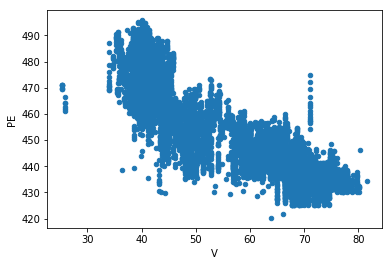

In [10]:
data.plot.scatter(x = 'V', y = 'PE')

## Accessing data

Pandas supports two ways to access a given column `C` of a data frame `data`. The two syntaxes `data.C` and `data['C']` are mostly equivalent.

In [11]:
# We've seen in the plot that we have multiple values for PE 
# for a given V. To make our lives easier, we take the mean
# values for all columns for any given V. We will discuss 
# details of grouping and summarizing in a later session.
import numpy as np
# data.V == data['V'] # also possible
data.V = np.round(data['V'], 1)
data = data.groupby('V', as_index=False)\
    .mean()

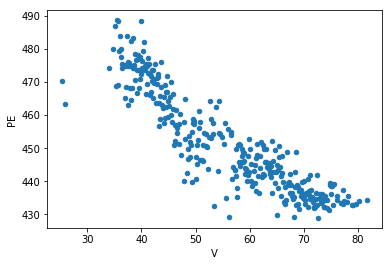

In [12]:
data.plot.scatter(x = 'V', y = 'PE')
# looking much better already

# Machine Learning

Let's get to work and take a closer look at KNN.

## Splitting in training and testing data.

We want to fit a K-Nearest Neighbor model to our data, as discussed in the theory part. The objective will be to do as good as possible with predicting PE for unseen values of `V`. So how can we test our model? We choose to train it only on, say, 70% of the data available and use the 30% we left out as a stand-in for unseen data to test model performance. The function `train_test_split` in `sklearn.model_selection` does the splitting for us.

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
?train_test_split

Signature: train_test_split(*arrays, **options)
Docstring:
Split arrays or matrices into random train and test subsets

Quick utility that wraps input validation and
``next(ShuffleSplit().split(X, y))`` and application to input data
into a single call for splitting (and optionally subsampling) data in a
oneliner.

Read more in the :ref:`User Guide <cross_validation>`.

Parameters
----------
*arrays : sequence of indexables with same length / shape[0]
    Allowed inputs are lists, numpy arrays, scipy-sparse
    matrices or pandas dataframes.

test_size : float, int, None, optional
    If float, should be between 0.0 and 1.0 and represent the proportion
    of the dataset to include in the test split. If int, represents the
    absolute number of test samples. If None, the value is set to the
    complement of the train size. By default, the value is set to 0.25.
    The default will change in version 0.21. It will remain 0.25 only
    if ``train_size`` is unspecified, otherwise it will 

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data[['V']],
                                                    data.PE,
                                                    test_size=0.3)

## Training our model

It's now time to train our K-Nearest Neighbor model.

In [16]:
from sklearn.neighbors import KNeighborsRegressor

In [17]:
# choose k=5 for starters
five_nearest = KNeighborsRegressor(n_neighbors = 5).fit(X_train, y_train)

In [18]:
# we can now use the model to predict PE for a few values of V
five_nearest.predict(50)

array([452.98605218])

In [19]:
five_nearest.predict(70)

array([435.91832469])

### How good did we do?

Let's consider the residual sum of squares,

$$\operatorname{RSS}(k) = \sum_i \left(\hat y_i^{(k)} - y_i\right)^2$$

where the sum runs over the indecs of testing data, and $\hat y_i^{(k)}$ is the k-Nearest Neighbor prediction belonging to our $i$-th testing data point, while $y_k$ is the known value.

In [20]:
sum((five_nearest.predict(X_test) - y_test)**2)

2870.9031452661197

In [21]:
# let's repeat for k = 10
ten_nearest = KNeighborsRegressor(n_neighbors = 10).fit(X_train, y_train)

In [22]:
sum((ten_nearest.predict(X_test) - y_test)**2)
# we did a little better ...

2960.6883564754903

In [23]:
# ... but tlet's be systematic here. We start 
# with defining a RSS function.
def RSS(f, X, y):
    return sum((f.predict(X) - y)**2)

In [24]:
RSS(ten_nearest, X_test, y_test)

2960.6883564754903

Let's do a scan over values for $k$ to better map out the dependence of RSS on $k$. What are sensible values? We start with 1 and stop when we have reached a $k$ of about half the size of the training sample.

In [25]:
len(y_train)

234

In [26]:
ks = np.arange(1, 100)

In [27]:
models = [KNeighborsRegressor(n_neighbors=k).fit(X_train, y_train)
          for k in ks]

In [35]:
import numpy

In [41]:
RSS_test = numpy.fromiter(map(lambda f: RSS(f, X_test, y_test), models), float)

In [38]:
import matplotlib.pyplot as plt

Text(0,0.5,'RSS')

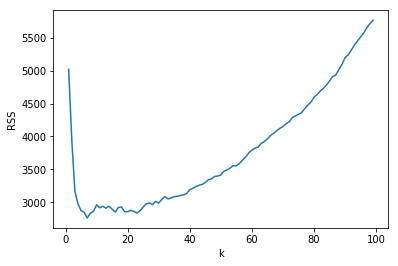

In [42]:
plt.plot(ks, RSS_test)
plt.xlabel('k')
plt.ylabel("RSS")

## Bias-Variance tradeoff

For very small $k$, the models has high *variance*, i.e. the error is dominated by the noise in the data. If we choose $k$ too big, the model becomes *biased*, meaning that we don't reproduce the function's shape (i.e. that of `PE` in dependence of `V` very well). Somewhere in between lies the "sweet spot". A lot of work in machine learning projects goes into identifying that sweet spot.

## Training data

Let's now have a look at the RSS on our **training** data. What do we expect? We won't be able to do much on the high-$k$ side since our function just can't fit the underlying distribution well. But on the low-$k$ side it should have a decisive advantage: It *knows* the noise and should produce for $k$=1 a perfect fit. 

In [44]:
RSS_train = numpy.fromiter(map(lambda f: RSS(f, X_train, y_train), models), float)

Text(0,0.5,'RSS_train')

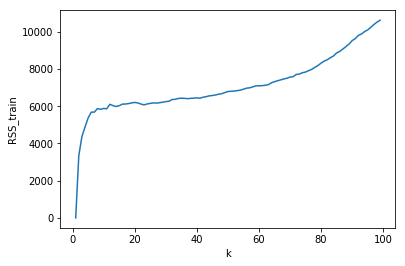

In [45]:
plt.plot(ks, RSS_train)
plt.xlabel('k')
plt.ylabel("RSS_train")

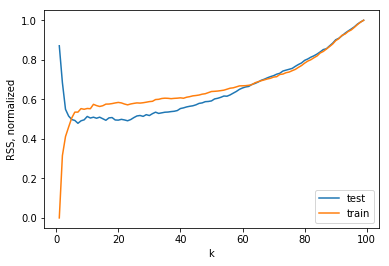

In [46]:
# compare the two ...
plt.plot(ks, RSS_test / RSS_test[-1], label = 'test')
plt.plot(ks, RSS_train / RSS_train[-1], label = 'train')
plt.xlabel('k')
plt.ylabel("RSS, normalized")
plt.legend()

## Degrees of freedom

Another way of looking at this is analyzing the dependence of RSS on the degrees of freedom. Too few degrees of freedom don't allow us to reproduce the dependence of `PE` on `V` accurately. Too many degrees of freedm and we're "chasing noise".

Text(0,0.5,'RSS')

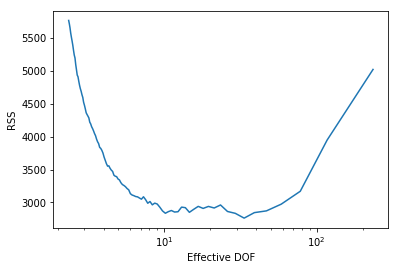

In [47]:
plt.plot(float(len(y_train))/ ks, RSS_test)
plt.xscale('log')
plt.xlabel('Effective DOF')
plt.ylabel('RSS')

## Functional form

Let's finally look at the functonal form of our k-Nearest Neighbor models. For a low $k$, we expect a high-noise, erratic behavior, while for high $k$, we expect a smoother and smoother function.

In [48]:
plot_ks = (1, 5, 30)
plot_models = [models[list(ks).index(k)] for k in plot_ks]

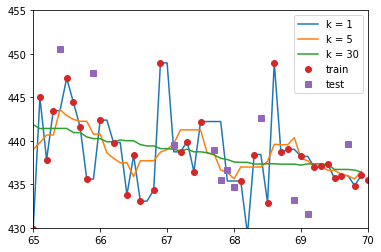

In [49]:
for k, f in zip(plot_ks, plot_models):
    xs = [[i] for i in np.arange(65, 70, 0.1)]
    plt.plot(xs, f.predict(xs), label="k = {}".format(k))
plt.plot(X_train, y_train, 'o', label='train')
plt.plot(X_test, y_test, 's', label='test')
plt.xlim(65, 70)
plt.ylim(430, 455)
plt.legend()